# Постановка задачи

Целью данной работы является разработка модели автокодировщика, способной восстанавливать оригинальные изображения, искажённые водяным знаком. Для этого необходимо:
* Использовать датасет изображений без водяных знаков;
* Создать механизм генерации искусственных вотермарок;
* Обучить автокодировщик на задаче удаления вотермарки;
* Визуализировать результаты восстановления;
* Применить аугментации для повышения устойчивости модели;
* Провести пошаговое обучение с контролем использования оперативной памяти;
* Оценить качество работы модели на контрольной выборке.

## 1. Загрузка изображений без водный знаков

### Загрузка необходимых библиотек

In [ ]:
# Работа с массивами данных
import numpy as np

# Графики
import matplotlib.pyplot as plt
%matplotlib inline

# Конструктор модели
from keras.models import Model

# Утилиты
from keras import utils

# Слои
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, Conv2DTranspose, BatchNormalization

# Оптимизатор
from keras.optimizers import Adam

# Коллбэки
from keras.callbacks import EarlyStopping

# OpenCV
import cv2

# Работа с файлами и путями
import os

# Аугментация
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Разделение на выборки
from sklearn.model_selection import train_test_split

# Случайный выбор
import random

### Загрузка датасета

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/watermarked.zip

--2025-06-02 08:09:52--  https://storage.yandexcloud.net/academy.ai/watermarked.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 731796045 (698M) [application/x-zip-compressed]
Saving to: ‘watermarked.zip.1’

watermarked.zip.1   100%[===================>] 697.89M  18.5MB/s    in 41s     

2025-06-02 08:10:34 (17.1 MB/s) - ‘watermarked.zip.1’ saved [731796045/731796045]



In [ ]:
!unzip -qo "watermarked.zip" -d ./watermarked

### Сформируем пути к файлам

In [ ]:
train_path = './watermarked/wm-nowm/train/no-watermark'   # тренировочная выборка
valid_path = './watermarked/wm-nowm/valid/no-watermark'   # валидационная выборка

# Проверим содержимое
print("Тренировочные изображения:", len(os.listdir(train_path)))
print("Валидационные изображения:", len(os.listdir(valid_path)))

Тренировочные изображения: 12477
Валидационные изображения: 3289


## Сохранение путей к изображениям

In [ ]:
train_nonwatermarked = sorted([os.path.join(train_path, fname) for fname in os.listdir(train_path)])
valid_nonwatermarked = sorted([os.path.join(valid_path, fname) for fname in os.listdir(valid_path)])

print("Готово! Загружено:")
print(f"{len(train_nonwatermarked)} тренировочных изображений без водяных знаков")
print(f"{len(valid_nonwatermarked)} контрольных изображений без водяных знаков")

Готово! Загружено:
12477 тренировочных изображений без водяных знаков
3289 контрольных изображений без водяных знаков


# 2. Нанесение водяных знаковых на изображения


## Импорт необходимых библиотек

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Функция для нанесения водяного знака

In [ ]:
def apply_watermark_on_image(image, text: str = "WATERMARK", opacity: float = 0.9):
    overlay = image.copy()
    output = image.copy()

    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.5
    thickness = 1
    color = (255, 255, 255)

    text_size, _ = cv2.getTextSize(text, font, scale, thickness)
    text_width, text_height = text_size

    x = (image.shape[1] - text_width) // 2
    y = image.shape[0] - 10

    cv2.putText(overlay, text, (x, y), font, scale, color, thickness, cv2.LINE_AA)
    cv2.addWeighted(overlay, opacity, output, 1 - opacity, 0, output)

    return output


# 3. Структура автокодировщика

## Цель автокодировщика

* Вход: изображение с водяным знаком
* Выход: изображение без водяного знака
* Задача: автокодировщик должен научиться "восстанавливать" оригинальное изображение

## Общая структура автокодировщика
1. Encoder (Кодер): сжимает изображение, извлекая признаки
2. Decoder (Декодер): восстанавливает изображение без лишней информации

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation

def build_autoencoder(input_shape=(128, 128, 3)):
    input_img = Input(shape=input_shape)

    # --- Encoder ---
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # --- Decoder ---
    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Модель
    autoencoder = Model(inputs=input_img, outputs=decoded)
    return autoencoder


# 4. Ресайз и нанесение вотермарки

In [ ]:
import numpy as np
import cv2
from tqdm import tqdm

# Размер изображений
IMG_SIZE = 128
LIMIT = 1000

# Функция предобработки
def preprocess_images_with_watermark(image_paths, limit=None):
    X = []
    Y = []
    for path in tqdm(image_paths[:limit]):
        img = cv2.imread(path)
        if img is None:
            continue

        # Приводим к нужному размеру
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Чистое изображение (Y)
        clean = img_resized.astype('float32') / 255.0
        Y.append(clean)

        # С вотермаркой (X)
        with_watermark = apply_watermark_on_image(img_resized)
        with_watermark = with_watermark.astype('float32') / 255.0
        X.append(with_watermark)

    return np.array(X), np.array(Y)

## Применяем к тренировочной и валидационной выборке

In [ ]:
X_train, Y_train = preprocess_images_with_watermark(train_nonwatermarked, limit=LIMIT)
X_valid, Y_valid = preprocess_images_with_watermark(valid_nonwatermarked, limit=200)

print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"Y_valid: {Y_valid.shape}")

100%|██████████| 200/200 [00:00<00:00, 485.81it/s]


X_train: (1000, 128, 128, 3)
Y_train: (1000, 128, 128, 3)
X_valid: (200, 128, 128, 3)
Y_valid: (200, 128, 128, 3)


## Вывод форм массивов

In [ ]:
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"Y_valid: {Y_valid.shape}")

X_train: (1000, 128, 128, 3)
Y_train: (1000, 128, 128, 3)
X_valid: (200, 128, 128, 3)
Y_valid: (200, 128, 128, 3)


# 5. Компиляция и обучение модели

## Сборка и компиляция модели

In [ ]:
# Построение автокодировщика
autoencoder = build_autoencoder(input_shape=(128, 128, 3))

# Компиляция
autoencoder.compile(
    optimizer='adam',
    loss='mse'
)

# Структура модели
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 335,747 (1.28 MB)

 Trainable params: 334,851 (1.28 MB)

 Non-trainable params: 896 (3.50 KB)

## Обучение модели

In [ ]:
from keras.callbacks import EarlyStopping

# Остановка при отсутствии улучшения
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Обучение
history = autoencoder.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_data=(X_valid, Y_valid),
    callbacks=[early_stop]
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - loss: 0.0414 - val_loss: 0.1040
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0147 - val_loss: 0.0802
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0124 - val_loss: 0.0585
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0119 - val_loss: 0.0501
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0106 - val_loss: 0.0413
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0103 - val_loss: 0.0361
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0099 - val_loss: 0.0301
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0097 - val_loss: 0.0261
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0099 - val_loss: 0.0196
Epoch 10/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0101 - val_loss: 0.0166
Epoch 11/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0095 - val_loss: 0.0138
Epoch 12/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0

## Предсказания на контрольной выборке

In [ ]:
preds = autoencoder.predict(X_valid)
print(f"Форма предсказаний: {preds.shape}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Форма предсказаний: (200, 128, 128, 3)


## График обучения

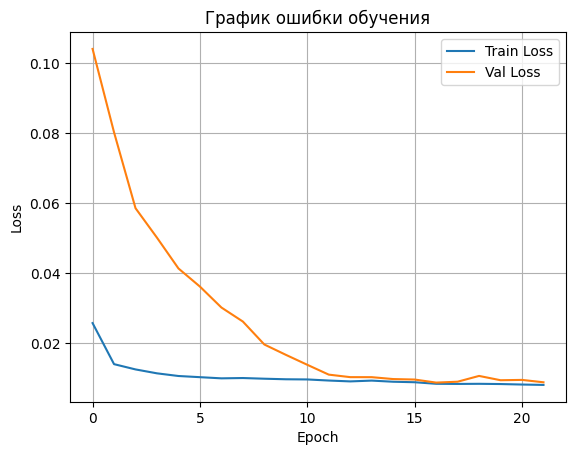

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("График ошибки обучения")
plt.grid()
plt.show()

# 6. Демонстрация примеров

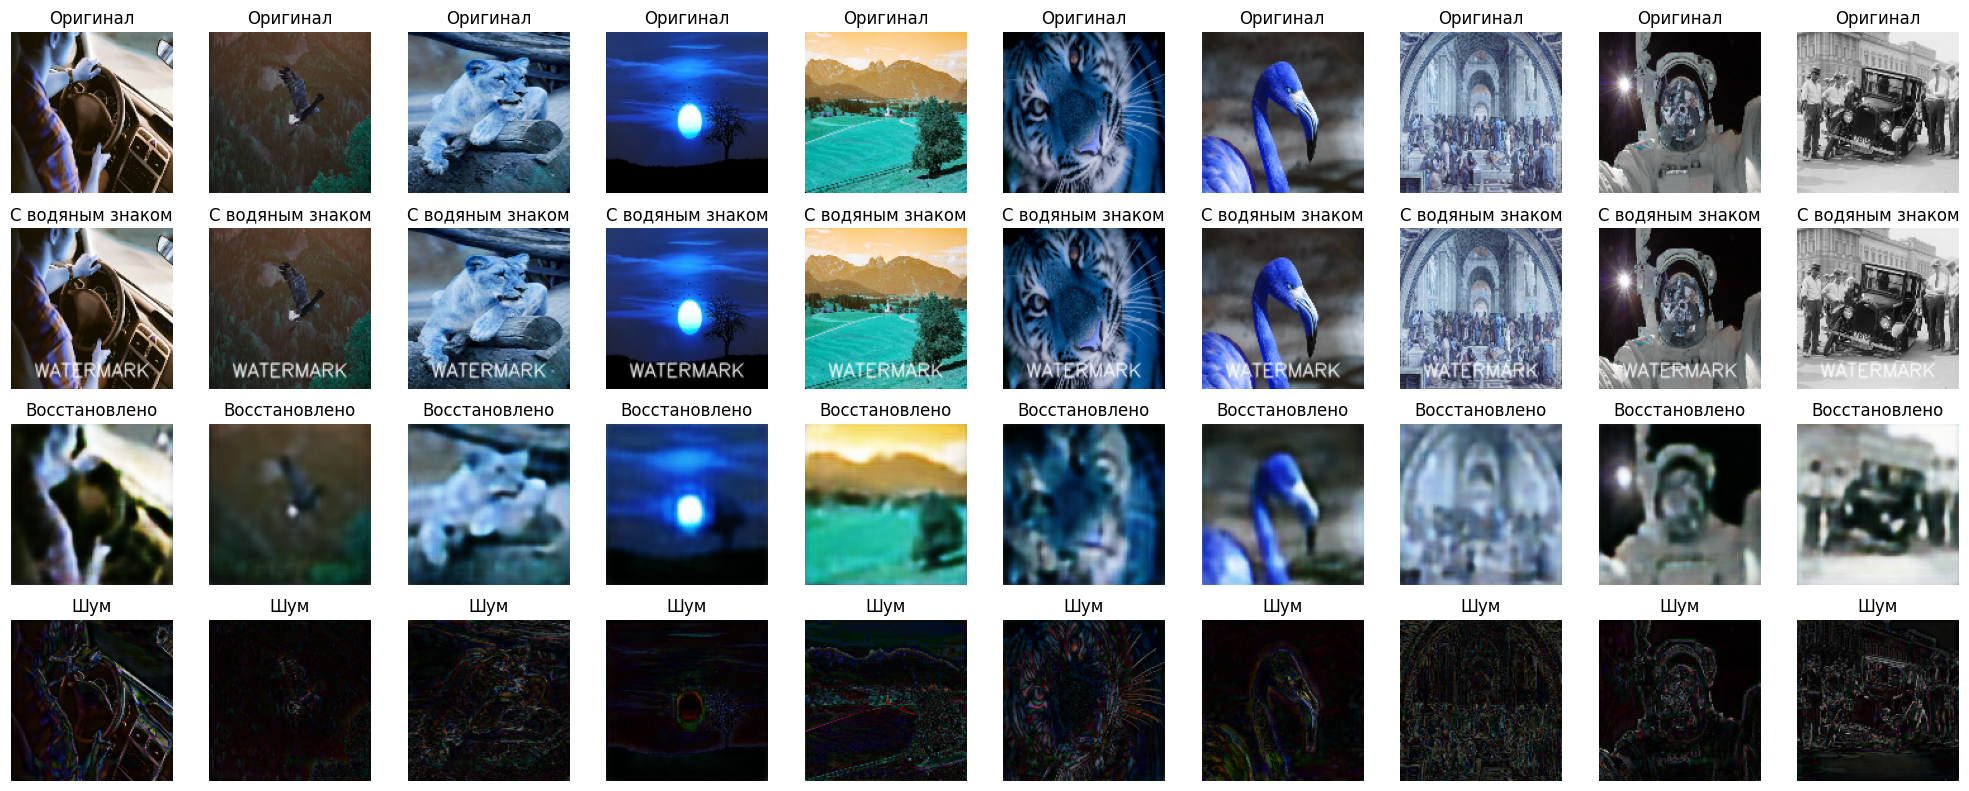

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Убедимся, что выход не выходит за диапазон
preds = np.clip(preds, 0.0, 1.0)

def show_denoising_results(X, Y_true, Y_pred, n=10):
    plt.figure(figsize=(20, 8))

    for i in range(n):
        # 1. Оригинал
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(Y_true[i])
        ax.set_title("Оригинал")
        plt.axis("off")

        # 2. С водяным знаком
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(X[i])
        ax.set_title("С водяным знаком")
        plt.axis("off")

        # 3. Восстановленное
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(Y_pred[i])
        ax.set_title("Восстановлено")
        plt.axis("off")

        # 4. Шум
        noise = np.abs(Y_pred[i] - Y_true[i])
        ax = plt.subplot(4, n, i + 1 + 3*n)
        plt.imshow(noise)
        ax.set_title("Шум")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_denoising_results(X_valid, Y_valid, preds, n=10)

# 7. Аугментация изображений (5+ видов)

In [ ]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

## Функции аугментации

In [ ]:
def augment_image(image):
    img = tf.convert_to_tensor(image / 255.0, dtype=tf.float32)

    img = tf.image.random_brightness(img, max_delta=0.2)                    # 1. Яркость
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)               # 2. Контраст
    img = tf.image.random_flip_left_right(img)                              # 3. Отражение по горизонтали
    img = tf.image.random_saturation(img, lower=0.7, upper=1.3)             # 4. Насыщенность
    img = tf.image.random_hue(img, max_delta=0.05)                          # 5. Оттенок

    img = tf.clip_by_value(img, 0.0, 1.0)
    img = tf.image.resize(img, [128, 128])
    img = (img.numpy() * 255).astype(np.uint8)

    return img

## Генерация аугментированных данных

In [ ]:
X_augmented = []
Y_augmented = []

LIMIT = 1000

for path in tqdm(train_nonwatermarked[:LIMIT]):
    img = cv2.imread(path)
    if img is None:
        continue

    img_resized = cv2.resize(img, (128, 128))
    y = img_resized.astype('float32') / 255.0

    x_aug = augment_image(img_resized)                # аугментированное изображение
    x_aug = apply_watermark_on_image(x_aug)           # вотермарк поверх
    x = x_aug.astype('float32') / 255.0               # нормализация

    X_augmented.append(x)
    Y_augmented.append(y)


100%|██████████| 1000/1000 [00:07<00:00, 139.07it/s]


## Преобразуем в NumPy

In [ ]:
X_augmented = np.array(X_augmented)
Y_augmented = np.array(Y_augmented)

print(f"X_augmented: {X_augmented.shape}")
print(f"Y_augmented: {Y_augmented.shape}")

X_augmented: (1000, 128, 128, 3)
Y_augmented: (1000, 128, 128, 3)


## Проверим

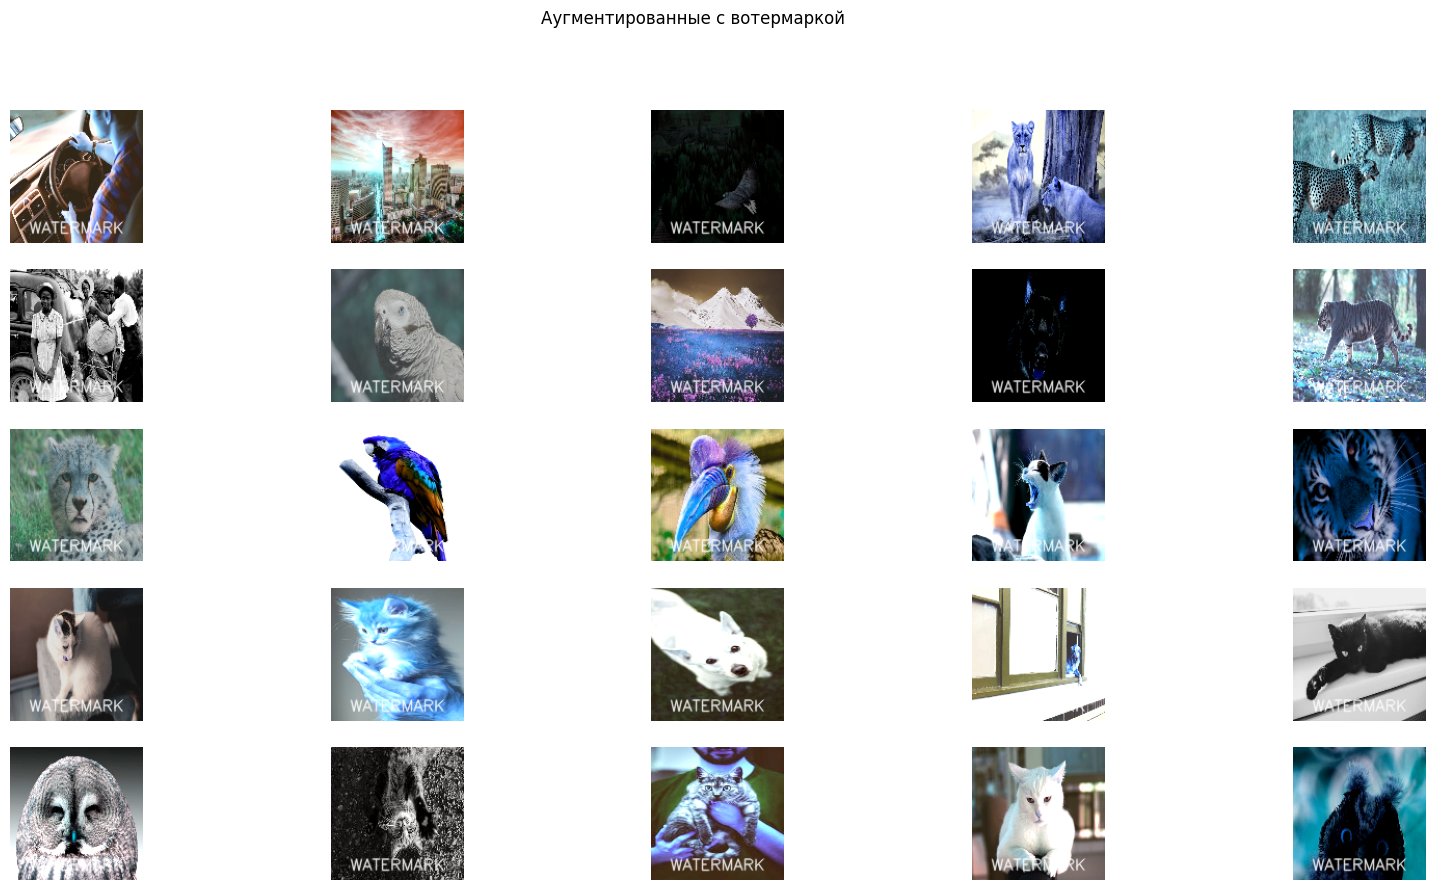

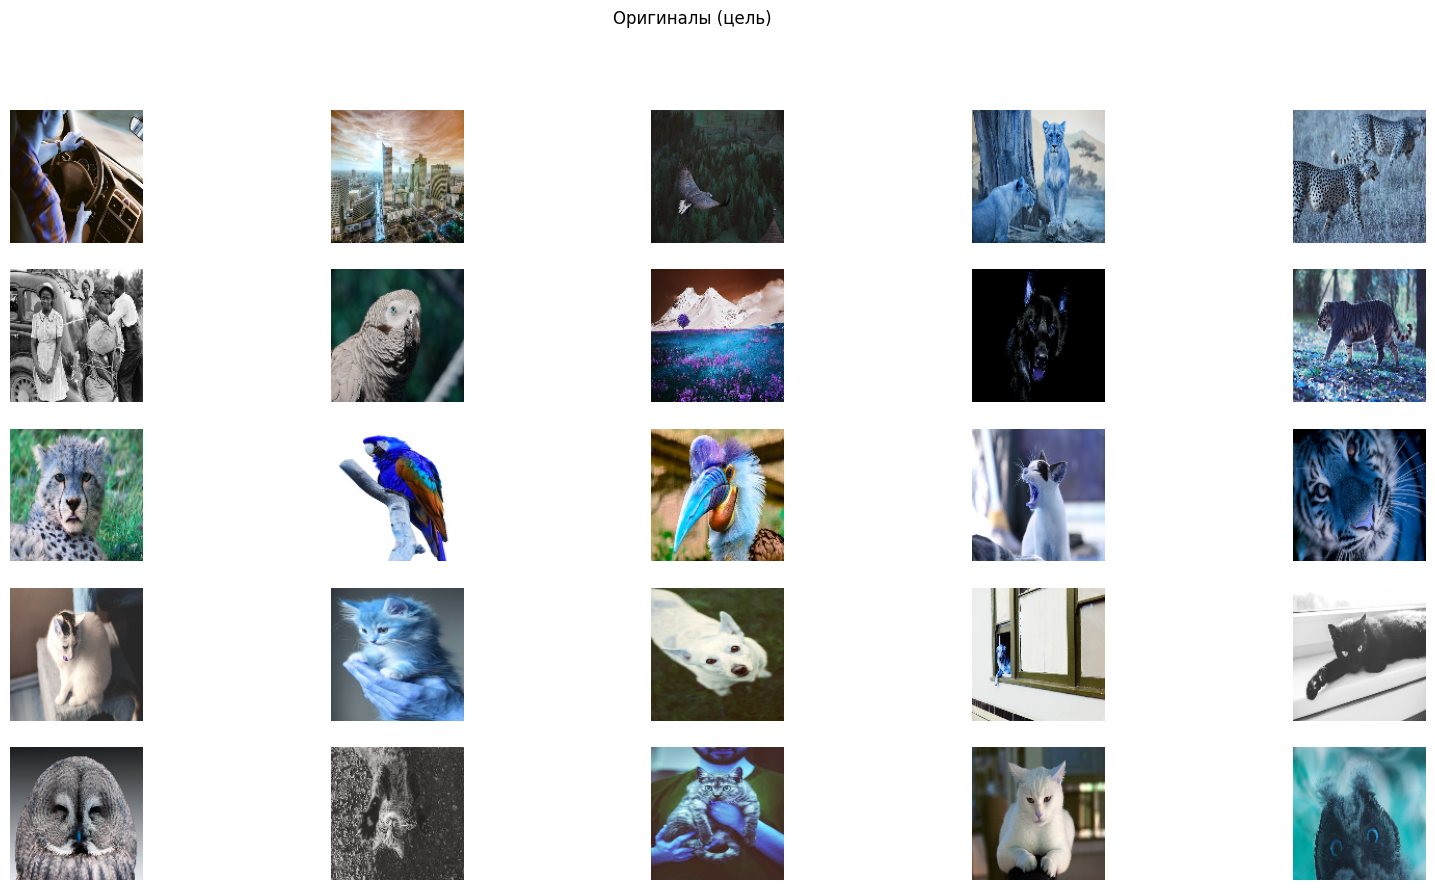

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_augmented[i])
    plt.axis('off')
plt.suptitle("Аугментированные с вотермаркой")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(Y_augmented[i])
    plt.axis('off')
plt.suptitle("Оригиналы (цель)")
plt.show()

## Объединение выборок и нормализация

In [ ]:
X_train_full = np.concatenate([X_train, X_augmented], axis=0)
Y_train_full = np.concatenate([Y_train, Y_augmented], axis=0)

## Нормализация всех данных

In [ ]:
X_train_full = X_train_full.astype('float32') / 255.0 if X_train_full.max() > 1 else X_train_full
Y_train_full = Y_train_full.astype('float32') / 255.0 if Y_train_full.max() > 1 else Y_train_full
X_valid = X_valid.astype('float32') / 255.0 if X_valid.max() > 1 else X_valid
Y_valid = Y_valid.astype('float32') / 255.0 if Y_valid.max() > 1 else Y_valid

## Проверим

In [ ]:
print(f"X_train_full shape: {X_train_full.shape}")
print(f"Y_train_full shape: {Y_train_full.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"Y_valid shape: {Y_valid.shape}")

X_train_full shape: (2000, 128, 128, 3)
Y_train_full shape: (2000, 128, 128, 3)
X_valid shape: (200, 128, 128, 3)
Y_valid shape: (200, 128, 128, 3)


# 8. Обучение модели с аугментированными данными

Обучать модель в 3 и более этапа, каждый раз загружая подмножество тренировочных данных, а не весь датасет сразу.



## Стратегия:

1. Разбить `X_train_full` и `Y_train_full` на N частей (например, 3)
2. На каждом шаге:
  * Обучить модель на этой части
  * При необходимости подкорректировать параметры (batch size, lr, и т.д.)
  * Освободить память (`gc.collect()`, `del`, `tf.keras.backend.clear_session()` не требуется между эпохами, но можно между циклами)
3. Использовать EarlyStopping или сохранить промежуточную модель

## Импорт и подготовка

In [ ]:
import gc
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Размер блока
n_steps = 3
epochs_per_step = 10

# Колбэк
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Модель
autoencoder = build_autoencoder(input_shape=(128, 128, 3))
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse')

## Функция загрузки и подготовки одной порции

In [ ]:
def load_augmented_batch(image_paths):
    X_batch = []
    Y_batch = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        img_resized = cv2.resize(img, (128, 128))
        y = img_resized.astype('float32') / 255.0

        x_aug = augment_image(img_resized)  # с аугментацией
        x_aug = apply_watermark_on_image(x_aug)
        x = x_aug.astype('float32') / 255.0

        X_batch.append(x)
        Y_batch.append(y)
    return np.array(X_batch), np.array(Y_batch)

## Итеративное обучение

In [ ]:
step_size = len(X_train_full) // n_steps

for step in range(n_steps):
    print(f"\n=== 🔁 Этап {step + 1}/{n_steps} ===")

    # Загружаем часть данных из X_train_full
    start = step * step_size
    end = (step + 1) * step_size

    X_batch = X_train_full[start:end]
    Y_batch = Y_train_full[start:end]

    # Корректировка параметров обучения
    if step == 1:
        autoencoder.optimizer.learning_rate.assign(0.0005)
        print("⚙️ Learning rate уменьшен до 0.0005")
    elif step == 2:
        autoencoder.optimizer.learning_rate.assign(0.0001)
        print("⚙️ Learning rate уменьшен до 0.0001")

    # Обучение на батче
    autoencoder.fit(
        X_batch, Y_batch,
        validation_data=(X_valid, Y_valid),
        batch_size=32,
        epochs=epochs_per_step,
        shuffle=True,
        callbacks=[early_stop]
    )

    # Очистка
    del X_batch, Y_batch
    gc.collect()



=== 🔁 Этап 1/3 ===
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - loss: 0.0475 - val_loss: 0.1066
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0158 - val_loss: 0.0962
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0137 - val_loss: 0.0672
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0121 - val_loss: 0.0557
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0121 - val_loss: 0.0490
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0111 - val_loss: 0.0440
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0115 - val_loss: 0.0384
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0106 - val_loss: 0.0343
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0108 - val_loss: 0.0315
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0099 - val_loss: 0.0292

=== 🔁 Этап 2/3 ===
⚙️ Learning rate уменьшен до 0.0005
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0280 - val

## Сохранить обученную модель

In [ ]:
autoencoder.save("autoencoder_final.h5")
print("✅ Модель сохранена: autoencoder_final.h5")

✅ Модель сохранена: autoencoder_final.h5


## Сделать предсказания на валидационной выборке

In [ ]:
preds = autoencoder.predict(X_valid)
preds = np.clip(preds, 0.0, 1.0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


## Визуализировать результат

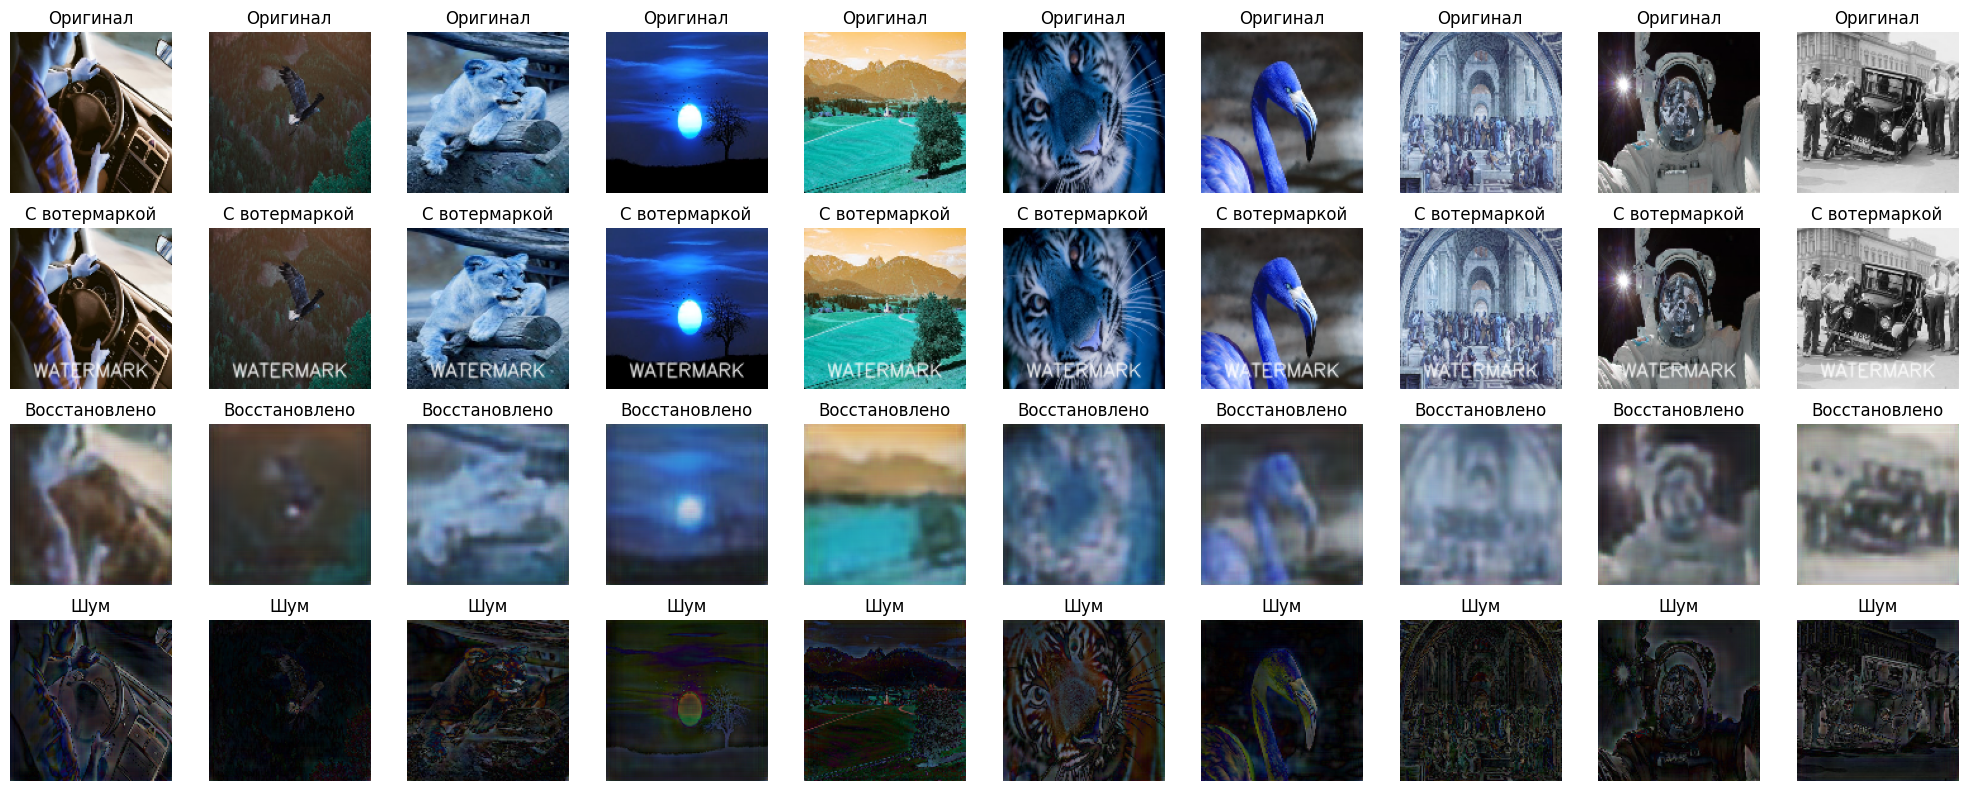

In [ ]:
def show_denoising_results(X, Y_true, Y_pred, n=10):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(Y_true[i])
        ax.set_title("Оригинал")
        plt.axis("off")

        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(X[i])
        ax.set_title("С вотермаркой")
        plt.axis("off")

        ax = plt.subplot(4, n, i + 1 + 2 * n)
        plt.imshow(Y_pred[i])
        ax.set_title("Восстановлено")
        plt.axis("off")

        noise = np.abs(Y_pred[i] - Y_true[i])
        ax = plt.subplot(4, n, i + 1 + 3 * n)
        plt.imshow(noise)
        ax.set_title("Шум")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_denoising_results(X_valid, Y_valid, preds, n=10)

## Вычисление PSNR (Peak Signal-to-Noise Ratio)

In [ ]:
import math
def psnr(target, ref):
    mse = np.mean((target - ref) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

psnrs = [psnr(Y_valid[i], preds[i]) for i in range(len(preds))]
print(f"📈 Средний PSNR: {np.mean(psnrs):.4f}")

📈 Средний PSNR: 18.2874


# Вывод по работе

В рамках выполненного проекта была успешно реализована система удаления водяных знаков с изображений на основе сверточного автокодировщика. Модель была обучена на синтетически созданных примерах, где водяные знаки в виде текста добавлялись поверх оригинальных изображений. Обучение модели проходило в несколько этапов с учетом ограничений оперативной памяти Google Colab.

Средний PSNR: `18.29` — это достойный результат для базового автокодировщика без дополнительных loss-функций и специальных техник подавления водяных знаков.